In [1]:
import torch
import matplotlib.pyplot as plt
from torch import nn, Tensor
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
import numpy as np

In [2]:
from torchvision import datasets, transforms
import torch

batch_size=64

digit = 1  # chiffre sur lequel tu veux entraîner
transform = transforms.Compose([transforms.ToTensor()])

CIFAR10_full = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
indices = [i for i, label in enumerate(CIFAR10_full.targets) if label == digit]
CIFAR10_class = torch.utils.data.Subset(CIFAR10_full, indices)

train_loader = torch.utils.data.DataLoader(CIFAR10_class, batch_size, shuffle=True)


In [3]:
len(indices)

5000

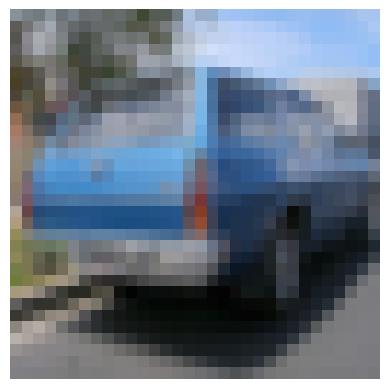

Label : 1
Shape de l'image : torch.Size([32, 32, 3])


In [4]:
img_sampled, label = CIFAR10_class[np.random.randint(0,5000)]  # récupère l'image et le label
img_sampled = img_sampled.permute(1, 2, 0)  # passe de (C,H,W) à (H,W,C)

plt.imshow(img_sampled)
plt.axis('off')
plt.show()

print("Label :", label)
print("Shape de l'image :", img_sampled.shape)

In [5]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [6]:
import unet as UNET_OAI

model4 = UNET_OAI.UNetModel(
    image_size=32,                # Taille de l'entrée 
    in_channels=3,                # Nombre de canaux
    model_channels=96,            # Nombre de filtres
    out_channels=3,
    num_res_blocks=2,             # Nombre de blocks résiduels
    attention_resolutions=[16],   # Résolution ou appliquer l'attention
    channel_mult=[1, 2, 2, 2],    # Profondeur du UNET
    dropout=0.1,
    use_checkpoint=False,        
)

In [7]:
from nn import timestep_embedding

n_epochs = 3000
model4 = model4.to(device)

optim = torch.optim.Adam(model4.parameters(), lr=1e-4)

for epoch in range(n_epochs):

    # --- Charger un batch ---
    x_1, _ = next(iter(train_loader))
    x_1 = x_1.to(device).float()

    # --- Bruit de départ (x0) ---
    x_0 = torch.randn_like(x_1)

    B = x_1.size(0)

    # --- Temps Flow Matching ---
    t = torch.rand(B, device=device)

    # --- Interpolation ---
    x_t = (1 - t.view(B,1,1,1)) * x_0 + t.view(B,1,1,1) * x_1

    # --- Champ de vecteur "réel" ---
    v_true = x_1 - x_0

    # --- Embedding temporel (OBLIGATOIRE pour UNet OpenAI) ---
    v_pred = model4(x_t, t * 1000)


    # --- Loss Flow Matching ---
    loss = ((v_pred - v_true) ** 2).mean()

    # --- Optimisation ---
    optim.zero_grad()
    loss.backward()
    optim.step()

    if(epoch%100 == 0):
        print(f"[epoch {epoch}] loss = {loss.item():.4f}")



[epoch 0] loss = 1.2917
[epoch 100] loss = 0.3759
[epoch 200] loss = 0.2043
[epoch 300] loss = 0.1536
[epoch 400] loss = 0.1471
[epoch 500] loss = 0.1170
[epoch 600] loss = 0.1100
[epoch 700] loss = 0.1231
[epoch 800] loss = 0.1063
[epoch 900] loss = 0.1119
[epoch 1000] loss = 0.1068
[epoch 1100] loss = 0.1292
[epoch 1200] loss = 0.1141
[epoch 1300] loss = 0.1350
[epoch 1400] loss = 0.1142
[epoch 1500] loss = 0.1293
[epoch 1600] loss = 0.1217
[epoch 1700] loss = 0.1401
[epoch 1800] loss = 0.1161
[epoch 1900] loss = 0.1201
[epoch 2000] loss = 0.1228
[epoch 2100] loss = 0.1056
[epoch 2200] loss = 0.1047
[epoch 2300] loss = 0.1412
[epoch 2400] loss = 0.1013
[epoch 2500] loss = 0.1100
[epoch 2600] loss = 0.1065
[epoch 2700] loss = 0.1162
[epoch 2800] loss = 0.1442
[epoch 2900] loss = 0.1239


In [6]:
def generate_image(model, steps=100, device="cuda"):
    model.eval()
    
    x_t = torch.randn(1, 3, 64, 64, device=device)
    dt = 1.0 / steps
    
    for step in range(steps):
        t_float = step * dt
        # convertir en entier pour l'embedding timestep
        if step == 0:
            print(t_float)
        t_int = torch.tensor([int(t_float * 1000)], device=device)
        v = model(x_t, t_int)
        x_t = x_t + dt * v  

    x_gen = torch.clamp(x_t, 0.0, 1.0)
    img = x_gen[0].permute(1, 2, 0).cpu().detach().numpy()
    
    return x_gen

In [7]:
chemin_sauvegarde = r"C:\Users\addda\Desktop\IMTA\MCE\DEEPL\PROJET\Flow_matching_deeplearning_project-main\trained models\unet_cifar10_cars.pth"


In [26]:
torch.save(model4.state_dict(), chemin_sauvegarde)
print(f"Modèle sauvegardé sous : {chemin_sauvegarde}")

Modèle sauvegardé sous : C:\Users\addda\Desktop\IMTA\MCE\DEEPL\PROJET\Flow_matching_deeplearning_project-main\trained models\unet_cifar10_cars.pth


In [8]:
state_dict = torch.load(chemin_sauvegarde, map_location=torch.device('cpu'))
model4.load_state_dict(state_dict)

<All keys matched successfully>

In [9]:
model4.to(device)

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=96, out_features=384, bias=True)
    (1): SiLU()
    (2): Linear(in_features=384, out_features=384, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1-2): 2 x TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 96, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Conv2d(96, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): SiLU()
          (1): Linear(in_features=384, out_features=96, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 96, eps=1e-05, affine=True)
          (1): SiLU()
          (2): Dropout(p=0.1, inplace=False)
          (3): Conv2d(96, 96, kernel_size=(3, 3), stride=

In [10]:
torch.cuda.empty_cache()

In [12]:
import torch
import matplotlib.pyplot as plt

def generate_and_plot(model, steps=100, device="cuda", image_size=32, channels=3, plot=True):
    model.eval()

    checkpoints = [0, 20, 40, 60, 80, 100]
    images_to_plot = []

    with torch.no_grad():
        x_t = torch.randn(1, channels, image_size, image_size, device=device)
        dt = 1.0 / steps
        img_init = torch.clamp(x_t, 0.0, 1.0)
        images_to_plot.append(img_init[0].permute(1, 2, 0).cpu().numpy())

        for step in range(steps):
            t_float = step * dt
            t_int = torch.tensor([int(t_float * 1000)], device=device)

            v = model(x_t, t_int)
            x_t = x_t + dt * v

            if step + 1 in checkpoints:
                img_snap = torch.clamp(x_t, 0.0, 1.0)
                images_to_plot.append(img_snap[0].permute(1, 2, 0).cpu().numpy())

    if plot:
        fig, axes = plt.subplots(1, 6, figsize=(20, 4))
        titles = ["Noise (0)", "Step 20", "Step 40", "Step 60", "Step 80", "Final (100)"]

        for i, ax in enumerate(axes):
            if i < len(images_to_plot):
                ax.imshow(images_to_plot[i])
                ax.set_title(titles[i])
            ax.axis('off')

        plt.tight_layout()
        plt.show()

    return x_t, images_to_plot[-1]

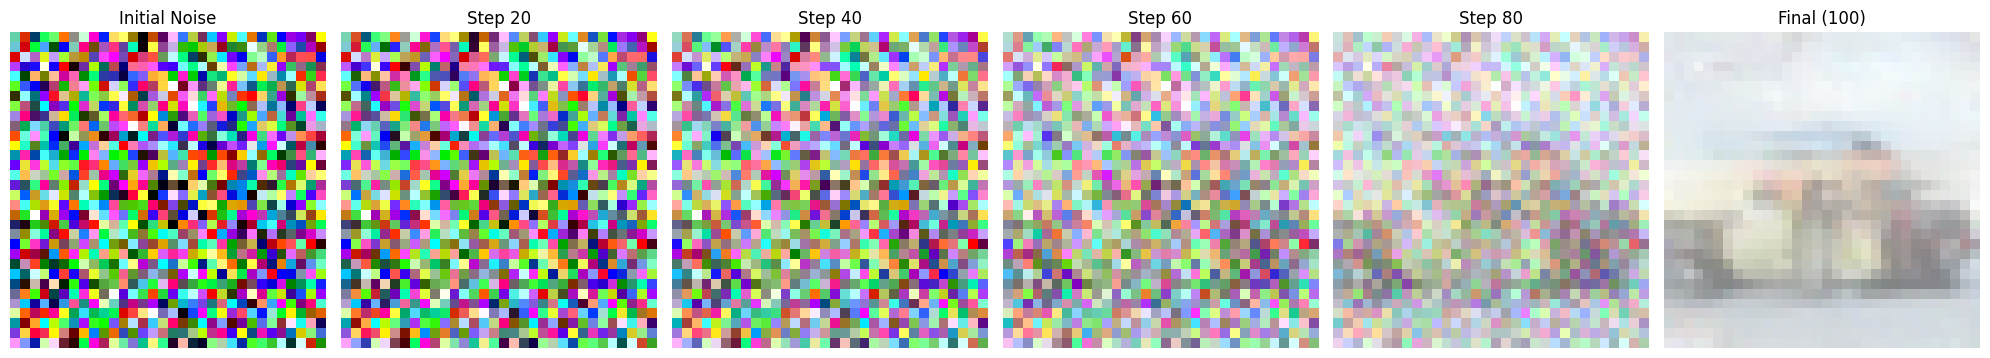

array([[[0.8852303 , 0.91330445, 0.9251436 ],
        [0.8777648 , 0.89387536, 0.91042334],
        [0.86985093, 0.90115714, 0.9144093 ],
        ...,
        [0.8656601 , 0.87903994, 0.9246042 ],
        [0.86892253, 0.8690872 , 0.90282756],
        [0.8954577 , 0.90348554, 0.8964323 ]],

       [[0.88407505, 0.90327585, 0.9271042 ],
        [0.88050795, 0.8931938 , 0.91959393],
        [0.87532246, 0.90809345, 0.920177  ],
        ...,
        [0.88529944, 0.9082455 , 0.93416864],
        [0.88446593, 0.8917509 , 0.91919494],
        [0.87076306, 0.87702066, 0.8966725 ]],

       [[0.8958929 , 0.8963474 , 0.92363536],
        [0.89367867, 0.9116566 , 0.9377413 ],
        [0.89757025, 0.91608906, 0.9383153 ],
        ...,
        [0.90432894, 0.9237348 , 0.94097173],
        [0.9005455 , 0.9126984 , 0.9308854 ],
        [0.8801458 , 0.8979088 , 0.92252934]],

       ...,

       [[0.79773   , 0.8360671 , 0.84403896],
        [0.83076215, 0.82058316, 0.8264862 ],
        [0.8554708 , 0

In [28]:
generate_and_plot_steps(model4, steps=100, device=device)

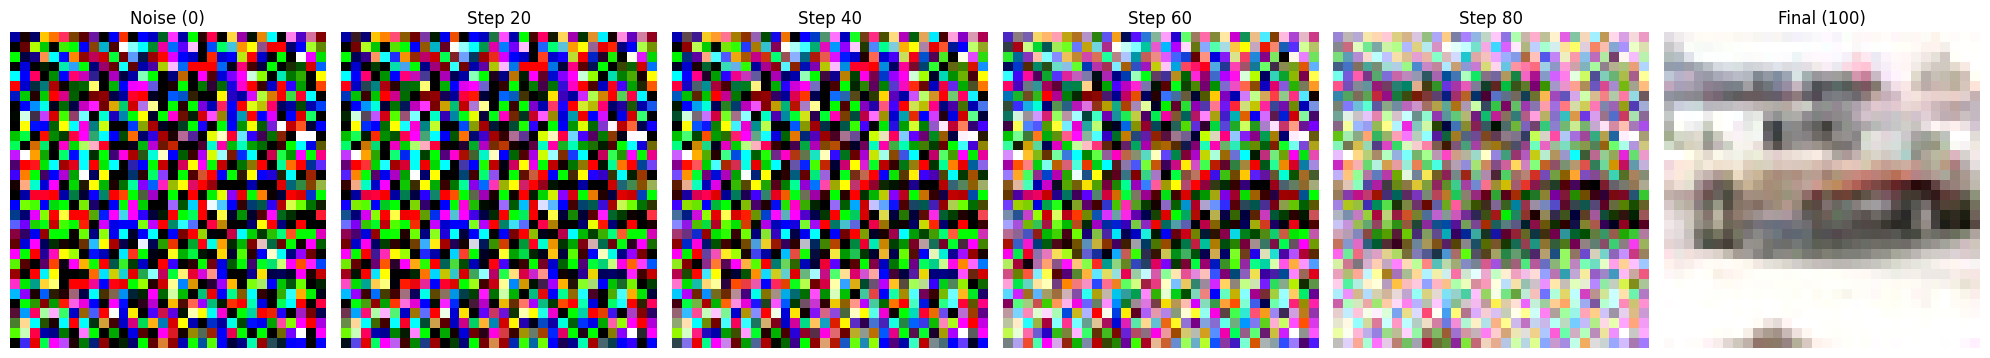

In [13]:
_, imgfinal = generate_and_plot(model4, steps=100, device=device)

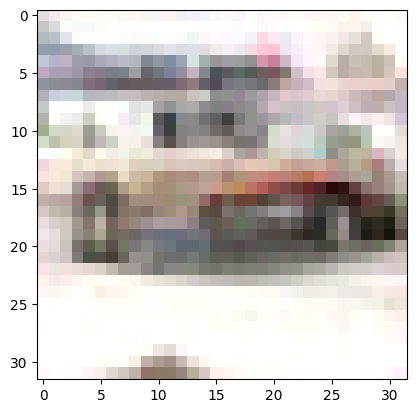

In [16]:
plt.imshow(imgfinal)

In [17]:
real_images = []

for images, _ in train_loader:
    real_images.append(images)

real_images = torch.cat(real_images, dim=0)

In [19]:
%pip install torch-fidelity

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [17]:
print("shape imgfinal", imgfinal.shape)
print("imgfinal type ", type(imgfinal))
print("shape imgnormal", img_sampled.shape)
print("imgnormal type ", type(img_sampled))

shape imgfinal (32, 32, 3)
imgfinal type  <class 'numpy.ndarray'>
shape imgnormal torch.Size([32, 32, 3])
imgnormal type  <class 'torch.Tensor'>


In [34]:
import torch
import numpy as np
from torchmetrics.image.fid import FrechetInceptionDistance
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

# --- Paramètres ---
num_generated = 50    # nombre d'images générées
num_real_batches = 10  # nombre de batches réelles à prendre

# --- Initialiser FID ---
fid = FrechetInceptionDistance(normalize=True).to(device)

# --- Récupérer plusieurs batches réelles ---
real_images_list = []
loader_iter = iter(train_loader)
for _ in range(num_real_batches):
    real_images_batch, _ = next(loader_iter)   # (batch_size, 3, H, W)
    real_images_batch = real_images_batch.float()  # valeurs déjà 0-1
    real_images_list.append(real_images_batch)

real_images = torch.cat(real_images_list, dim=0).to(device)  # concaténer tous les batches
fid.update(real_images, real=True)

# --- Générer un batch d'images ---
generated_images_list = []

for k in range(num_generated):
    _, imgfinal = generate_and_plot(model4, steps=100, device=device, plot=False)  # numpy ou tensor

    # Convertir en tensor et reshaper
    if isinstance(imgfinal, np.ndarray):
        img_tensor = torch.from_numpy(imgfinal).permute(2,0,1)  # (C,H,W)
    else:
        img_tensor = imgfinal.permute(2,0,1)

    img_tensor = img_tensor.unsqueeze(0).float()  # (1,C,H,W)

    # --- Normalisation automatique pour éviter les valeurs trop faibles ---
    img_tensor = (img_tensor - img_tensor.min()) / (img_tensor.max() - img_tensor.min() + 1e-8)

    generated_images_list.append(img_tensor.to(device))

    if k % 25 == 0:
        print(f"Généré {k} images")

generated_images_list = generated_images_list + memory

# Concaténer toutes les images générées
generated_batch = torch.cat(generated_images_list, dim=0).to(device)  # (num_generated,3,H,W)
fid.update(generated_batch, real=False)

# --- Calculer le FID ---
score = fid.compute()
print("FID:", score.item())



Généré 0 images
Généré 25 images
FID: 93.6999282836914


In [33]:
memory = generated_images_list
print(len(memory))


200


In [24]:
[3 , 2]+[3,2]

[3, 2, 3, 2]

In [18]:
# real_images : tensor concaténé de plusieurs batches
print("Real images shape:", real_images.shape)  # doit être (N_real, 3, H, W)


Real images shape: torch.Size([640, 3, 32, 32])


In [19]:
print("Generated images shape:", generated_batch.shape)  # doit être (N_fake, 3, H, W)


Generated images shape: torch.Size([100, 3, 32, 32])


In [27]:
print(real_images.min(), real_images.max())
print(generated_batch.min(), generated_batch.max())


tensor(0., device='cuda:0') tensor(1., device='cuda:0')
tensor(0., device='cuda:0') tensor(1., device='cuda:0')


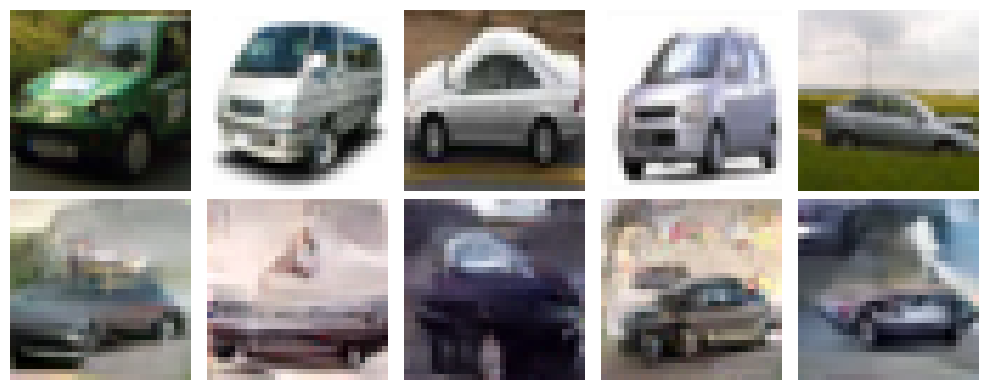

In [30]:
import matplotlib.pyplot as plt
import torchvision

num_to_show = 5

real_imgs = real_images[:num_to_show].cpu()
generated_imgs = generated_batch[:num_to_show].cpu()

fig, axes = plt.subplots(2, num_to_show, figsize=(num_to_show*2, 4))

for i in range(num_to_show):
    # Image réelle
    img_real = real_imgs[i]
    img_real_vis = (img_real - img_real.min()) / (img_real.max() - img_real.min() + 1e-8)
    img_real_vis = torchvision.transforms.ToPILImage()(img_real_vis)
    axes[0, i].imshow(img_real_vis)
    axes[0, i].axis('off')
    if i == 0:
        axes[0, i].set_ylabel('Réelles', fontsize=12)
    
    # Image générée
    img_fake = generated_imgs[i]
    img_fake_vis = (img_fake - img_fake.min()) / (img_fake.max() - img_fake.min() + 1e-8)
    img_fake_vis = torchvision.transforms.ToPILImage()(img_fake_vis)
    axes[1, i].imshow(img_fake_vis)
    axes[1, i].axis('off')
    if i == 0:
        axes[1, i].set_ylabel('Générées', fontsize=12)

plt.tight_layout()
plt.show()
